In [0]:
! pip install comet-ml

In [0]:
! git clone https://github.com/dudeperf3ct/TextRecognizer.git

In [3]:
%cd TextRecognizer/Experiment-2/notebooks

/content/TextRecognizer/Experiment-2/notebooks


In [4]:
%%writefile ../src/data/emnist_lines.py

"""
EMNIST dataset. Downloads from NIST website and saves as .npz file if not already present.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import h5py
from pathlib import Path
from tensorflow.keras.utils import to_categorical
from collections import defaultdict
import sys
sys.path.append(str(Path(__file__).resolve().parents[2]))
from src.data.dataset import Dataset
from src.data.emnist_dataset import EMNIST
from src.data.sentence_generator import SentenceGenerator
import numpy as np
np.random.seed(42)

root_folder = Path(__file__).resolve().parents[2]/'data'
raw_folder = root_folder/'raw'
processed_folder = root_folder/'processed'

class EMNISTLines(Dataset):
    """
    Here we will create a synthetic dataset using EMNIST dataset and
    we will use text from Brown Corpus avaliable on NLTK 
    
    Args :
    max_length : Maximum length of the labels
    max_overlap : Overlap to stitch images together
    num_train : Number of train samples
    num_test : Number of test samples
    """
    def __init__(self, max_length : int = 34, max_overlap : float = 0.33, num_train : int = 25000, num_test : int = 5000):
        self.dataset = EMNIST()
        (_, _), (_, _) = self.dataset.load_data()
        self.mapping = augment_emnist_mapping(self.dataset.mapping)
        self.inverse_mapping = {v: k for k, v in self.mapping.items()}
        self.max_length = max_length
        self.max_overlap = max_overlap
        self.input_shape = (self.dataset.input_shape[0], self.dataset.input_shape[1] * max_length)
        self.num_classes = len(self.mapping)
        self.output_shape = (self.max_length, self.num_classes)
        
        self.num_train = num_train
        self.num_test = num_test
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None

    @property
    def data_filename(self):
        return processed_folder / f'ml_{self.max_length}_mo{self.max_overlap}_ntr{self.num_train}_nte{self.num_test}.h5'

    def generate_data(self, split : str):

        print('[INFO] Creating EmnistLines Dataset...')
        data = self.dataset
        classes = data.mapping
        train_labels = get_labels(data.y_train, data.mapping)
        test_labels = get_labels(data.y_test, data.mapping)
        
        trn_dict = create_data_dict(data.x_train, train_labels, self.mapping)
        test_dict = create_data_dict(data.x_test, test_labels, self.mapping)

        num = self.num_train if split == 'train' else self.num_test
        data_dict = trn_dict if split == 'train' else test_dict

        sent = SentenceGenerator(self.max_length)

        print('[INFO] Saving EmnistLines Dataset to HDF5...')
        with h5py.File(self.data_filename, 'a') as f:
            x, y = create_image_string_dataset(num, data_dict, sent, self.max_overlap)
            y = convert_strings_to_categorical_labels(y, self.inverse_mapping)
            f.create_dataset(f'x_{split}', data=x, dtype='u1', compression='lzf')
            f.create_dataset(f'y_{split}', data=y, dtype='u1', compression='lzf')

    def load_data(self):
        """ Load EMNIST Lines dataset"""
        if not os.path.exists(self.data_filename):
            self.generate_data(split='train')
            self.generate_data(split='test')
 
        print('[INFO] EmnistLines Dataset loading data from HDF5...')
        with h5py.File(self.data_filename, 'r') as f:
            self.x_train = f['x_train'][:]
            self.y_train = f['y_train'][:]
            self.x_test = f['x_test'][:]
            self.y_test = f['y_test'][:]


    def __repr__(self):
        return (
            'EMNIST Lines Dataset\n'
            f'Max length: {self.max_length}\n'
            f'Max overlap: {self.max_overlap}\n'
            f'Num classes: {self.num_classes}\n'
            f'Input shape: {self.input_shape}\n'
            f'Train: {self.x_train.shape} {self.y_train.shape}\n'
            f'Test: {self.x_test.shape} {self.y_test.shape}\n'
        )

def create_data_dict(samples, labels, mapping) -> dict :
    # create a dict where keys are labels and values are image array
    data_dict = defaultdict(list)
    for sample, label in zip(samples, labels.flatten()):
        data_dict[label].append(sample)
    return data_dict

def stitch_image_string(string : str, data_dict : dict, max_overlap : float) -> np.ndarray :
        # get random sample of image for each corresponding character
        selected_images = []
        zero_image = np.zeros((28, 28), np.uint8)
        for char in string:
            samples = data_dict[char]
            rnd_sample = samples[np.random.choice(len(samples))] if samples else zero_image
            selected_images.append(rnd_sample.reshape(28, 28))
        # stitch the selected images to form a uniform image
        overlap = np.random.rand() * max_overlap
        N = len(selected_images)
        H, W = np.array(selected_images)[0].shape
        #print (N, overlap, H, W)
        next_overlap_width = W - int(overlap * W)
        concatenated_image = np.zeros((H, W * N), np.uint8)
        x = 0
        for image in selected_images:
            concatenated_image[:, x:(x + W)] += image
            x += next_overlap_width
        return np.minimum(255, concatenated_image)

def create_image_string_dataset(num, data_dict, sent, max_overlap):
    rnd_sentence = sent.generate()
    sample_image = stitch_image_string(rnd_sentence, data_dict, 0)  # Note that sample_image has 0 overlap
    images = np.zeros((num, sample_image.shape[0], sample_image.shape[1]), np.uint8)
    labels = []
    for n in range(num):
        label = None
        for _ in range(5):  # Try 5 times to generate before actually erroring
            try:
                label = sent.generate()
                break
            except Exception:
                pass
        images[n] = stitch_image_string(label, data_dict, max_overlap)
        labels.append(label)
    return images, labels


def convert_strings_to_categorical_labels(labels, mapping):
    return np.array([
        to_categorical([mapping[c] for c in label], num_classes=len(mapping))
        for label in labels
    ])    

def get_labels(labels, mapping):    
    return np.array([mapping[np.where(labels[i]==1)[0][0]] for i in range(len(labels))])

def augment_emnist_mapping(mapping):
    """Augment the mapping with extra symbols."""
    # Extra symbol ' ' not present in EMNIST
    extra_symbols = [' ']

    # padding symbol
    extra_symbols.append('_')

    max_key = max(mapping.keys())
    extra_mapping = {}
    for i, symbol in enumerate(extra_symbols):
        extra_mapping[max_key + 1 + i] = symbol

    return {**mapping, **extra_mapping}

def main():
    """Load EMNISTLines dataset and print INFO."""

    dataset = EMNISTLines()
    dataset.load_data()

    print(dataset)

if __name__ == '__main__':
    main()

Overwriting ../src/data/emnist_lines.py


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [0]:
import sys
sys.path.append('..')

In [0]:
from src.data.emnist_lines import EMNISTLines
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict

In [9]:
dataset = EMNISTLines()
dataset.load_data()

0.00B [00:00, ?B/s]

[INFO] Downloading raw dataset...


709MB [00:42, 17.7MB/s]                           


[INFO] Download complete..
[INFO] Unzipping raw dataset...
[INFO] Unzipping complete
[INFO] Loading training and test data from .mat file...
[INFO] Balancing classes to reduce amount of data...
[INFO] Saving to HDF5 in a compressed format...
[INFO] Saving essential dataset parameters...
[INFO] Cleaning up...
[INFO] Creating EmnistLines Dataset...
[nltk_data] Downloading package brown to
[nltk_data]     /content/TextRecognizer/Experiment-2/data/raw/nltk...
[nltk_data]   Unzipping corpora/brown.zip.
[INFO] Saving EmnistLines Dataset to HDF5...
[INFO] Creating EmnistLines Dataset...
[INFO] Saving EmnistLines Dataset to HDF5...
[INFO] EmnistLines Dataset loading data from HDF5...


In [10]:
print(dataset)

EMNIST Lines Dataset
Max length: 34
Max overlap: 0.33
Num classes: 64
Input shape: (28, 952)
Train: (25000, 28, 952) (25000, 34, 64)
Test: (5000, 28, 952) (5000, 34, 64)



## EDA

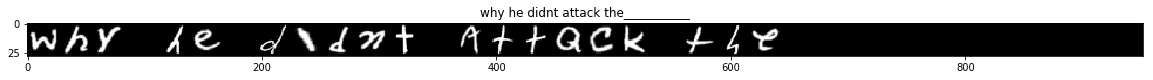

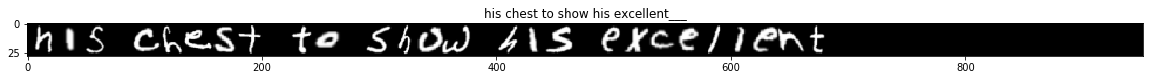

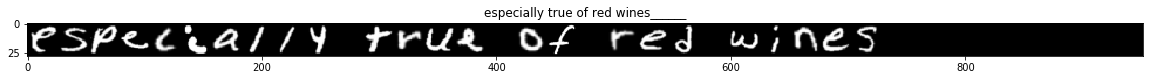

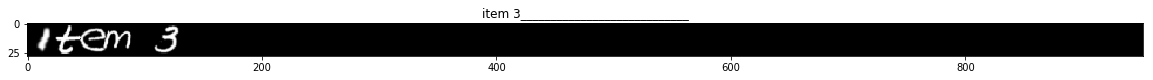

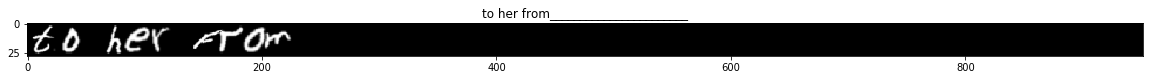

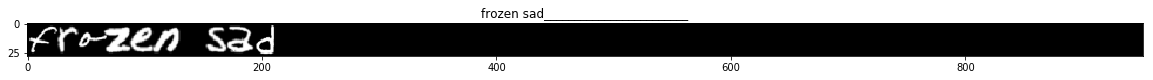

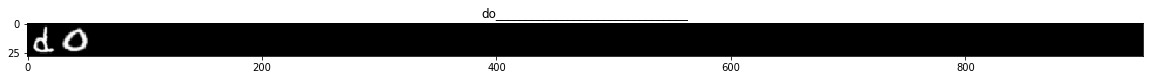

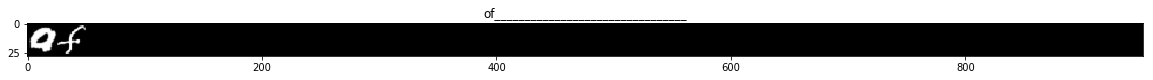

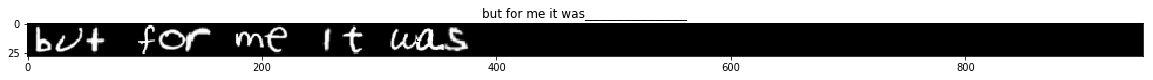

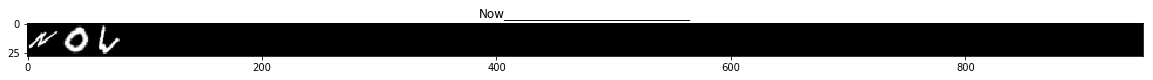

In [0]:
classes = dataset.mapping
# plot the images in the batch, along with the corresponding labels
size = 10
rnd_ind = np.random.randint(low=0, high=len(dataset.x_train), size=size)

for idx in rnd_ind:
    plt.figure(figsize=(20, 20))
    lbl = [classes[np.where(dataset.y_train[idx][i]==1)[0][0]] for i in range(34)]
    plt.title(''.join(lbl))
    plt.imshow(dataset.x_train[idx], cmap='gray')

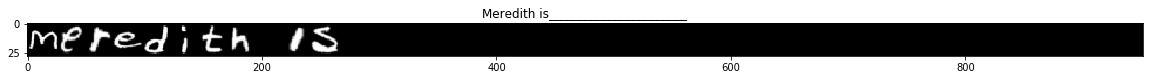

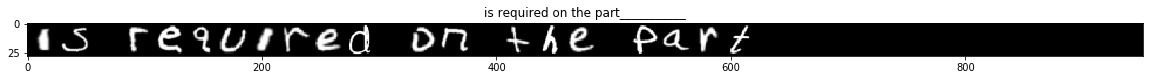

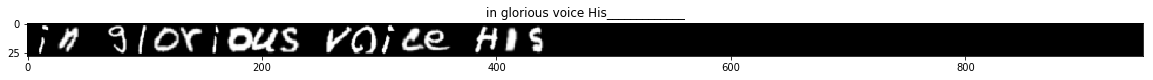

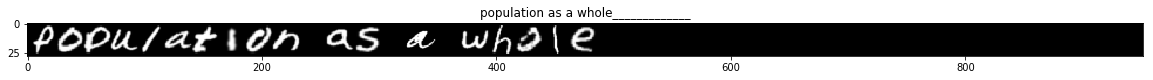

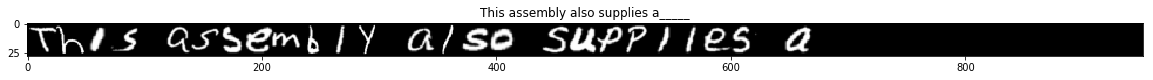

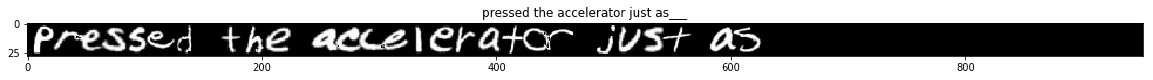

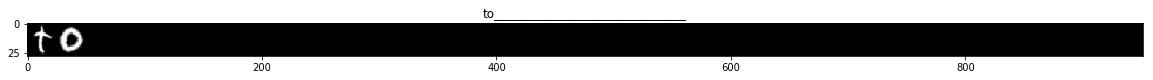

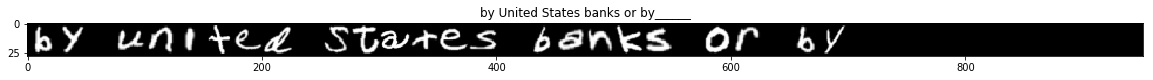

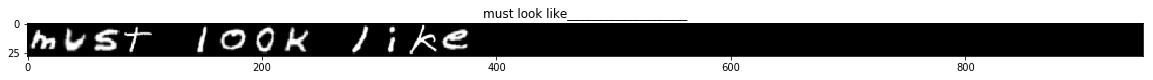

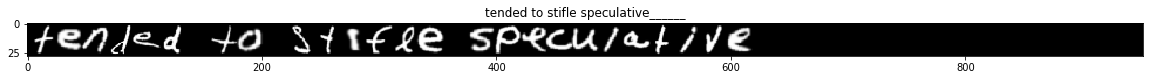

In [0]:
classes = dataset.mapping
# plot the images in the batch, along with the corresponding labels
size = 10
rnd_ind = np.random.randint(low=0, high=len(dataset.x_test), size=size)

for idx in rnd_ind:
    plt.figure(figsize=(20, 20))
    lbl = [classes[np.where(dataset.y_test[idx][i]==1)[0][0]] for i in range(34)]
    plt.title(''.join(lbl))
    plt.imshow(dataset.x_test[idx], cmap='gray')

In [0]:
def distribution(labels, classes):
    
    lbl_dist = dict.fromkeys(value for key,value in classes.items())
    lbl_dist = defaultdict(lambda:1)
    for idx in tqdm(range(len(labels))):
        lbl = [classes[np.where(dataset.y_train[idx][i]==1)[0][0]] for i in range(34)]
        for i in range(len(lbl)):
            lbl_dist[lbl[i]] += 1
    return lbl_dist

In [0]:
distribution(dataset.y_train, classes)

100%|██████████| 25000/25000 [00:02<00:00, 10476.82it/s]


defaultdict(<function __main__.distribution.<locals>.<lambda>>,
            {' ': 58370,
             '0': 323,
             '1': 476,
             '2': 229,
             '3': 153,
             '4': 129,
             '5': 168,
             '6': 119,
             '7': 80,
             '8': 132,
             '9': 196,
             'A': 951,
             'B': 561,
             'C': 578,
             'D': 313,
             'E': 224,
             'F': 351,
             'G': 256,
             'H': 649,
             'I': 1126,
             'J': 242,
             'K': 123,
             'L': 273,
             'M': 607,
             'N': 300,
             'O': 279,
             'P': 365,
             'Q': 18,
             'R': 248,
             'S': 803,
             'T': 1236,
             'U': 136,
             'V': 68,
             'W': 462,
             'X': 4,
             'Y': 127,
             'Z': 15,
             '_': 413366,
             'a': 29619,
             'b': 5312,
            

In [0]:
distribution(dataset.y_test, classes)

100%|██████████| 5000/5000 [00:00<00:00, 10852.42it/s]


defaultdict(<function __main__.distribution.<locals>.<lambda>>,
            {' ': 11441,
             '0': 52,
             '1': 91,
             '2': 48,
             '3': 28,
             '4': 27,
             '5': 29,
             '6': 17,
             '7': 17,
             '8': 28,
             '9': 28,
             'A': 209,
             'B': 107,
             'C': 128,
             'D': 62,
             'E': 48,
             'F': 63,
             'G': 46,
             'H': 136,
             'I': 240,
             'J': 43,
             'K': 23,
             'L': 52,
             'M': 114,
             'N': 75,
             'O': 61,
             'P': 79,
             'Q': 3,
             'R': 60,
             'S': 164,
             'T': 256,
             'U': 24,
             'V': 13,
             'W': 80,
             'Y': 16,
             'Z': 6,
             '_': 84284,
             'a': 5892,
             'b': 1074,
             'c': 2040,
             'd': 2966,
             '

In [11]:
%%writefile ../src/training/util.py

"""Function to train a model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
#from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping
from src.data.dataset import Dataset
from src.models.base_model import Model
from pathlib import Path
import numpy as np
import sys
sys.path.append(str(Path(__file__).resolve().parents[2]))
from src.visualization.visualize import plot_loss, plot_acc, save_model
from src.training.clr_callback import CyclicLR
from src.training.lr_find import LearningRateFinder
import matplotlib.pyplot as plt

EARLY_STOPPING = True
CYCLIC_LR = True
# adjust min_lr and max_lr after plotting lr_find
MIN_LR = 1e-4
MAX_LR = 1e-1
STEP_SIZE = 8
MODE = "triangular2"
SAVE_LR_PLOT = '../models/'

def train_model(
        model: Model,
        dataset: Dataset,
        epochs: int,
        batch_size: int,
        name : str,
        FIND_LR : bool = False) -> Model:
    """Train model."""
    callbacks = []

    if FIND_LR :
        # initialize the learning rate finder and then train with learning
        # rates ranging from 1e-10 to 1e+1
        print("[INFO] finding learning rate...")
        lrf = LearningRateFinder(model)
        lrf.find(
            dataset,
            1e-10, 
            1e+1,
            stepsPerEpoch=np.ceil((len(dataset['x_train']) / float(batch_size))),
            batchSize=batch_size)

        # plot the loss for the various learning rates and save the
        # resulting plot to disk
        lrf.plot_loss(name)
 
        # gracefully exit the script so we can adjust our learning rates
        # in the config and then train the network for our full set of
        # epochs
        print("[INFO] learning rate finder complete")
        print("[INFO] examine plot and adjust learning rates before training")

    else:
        if EARLY_STOPPING:
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, 
                            patience=5, verbose=1, restore_best_weights=True)
            callbacks.append(early_stopping)

        if CYCLIC_LR:
            cyclic_lr = CyclicLR(base_lr=MIN_LR, max_lr=MAX_LR,
                                step_size=STEP_SIZE * (dataset['x_train'].shape[0] // batch_size), 
                                mode=MODE)
            callbacks.append(cyclic_lr)

        model.network.summary()

        t = time.time()
        _history = model.fit(dataset=dataset, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            callbacks=callbacks,
                            lr=MIN_LR)
        print('[INFO] Training took {:2f} s'.format(time.time() - t))

        #plot_acc(_history, name)
        plot_loss(_history, name)
        save_model(model.network, name)

        return model

Overwriting ../src/training/util.py


## Training

In [0]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [0]:
! python ../src/training/train_model.py -b 128 -m LineModelCTC -n lstmctc -bb lenet -sq lstm -bi True -find_lr True

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] EmnistLines Dataset loading data from HDF5...
[INFO] Training shape:  (25000, 28, 952) (25000, 34, 64)
[INFO] Validation shape:  (1000, 28, 952) (1000, 34, 64)
[INFO] Test shape:  (4000, 28, 952) (4000, 34, 64)
[INFO] Setting up the model..
[INFO] Arguments passed to network... {'backbone': 'lenet', 'seq_model': 'lstm', 'bi': True}
W0817 12:04:50.730766 140319299286912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 12:04:50.751766 140319299286912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 12:04:50.759515 140319299286912 deprecation.py:506] From /content/TextRecognizer/Experiment-2/src/networks/sliding.py:

In [12]:
#1e-4 1e-1 with cyclic lr
! python ../src/training/train_model.py -b 128 -m LineModelCTC -n lstmctc -bb lenet -sq lstm -bi True -e 50

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] EmnistLines Dataset loading data from HDF5...
[INFO] Training shape:  (25000, 28, 952) (25000, 34, 64)
[INFO] Validation shape:  (1000, 28, 952) (1000, 34, 64)
[INFO] Test shape:  (4000, 28, 952) (4000, 34, 64)
[INFO] Setting up the model..
[INFO] Arguments passed to network... {'backbone': 'lenet', 'seq_model': 'lstm', 'bi': True}
W0817 19:32:48.669059 140364756326272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 19:32:48.689097 140364756326272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 19:32:48.696851 140364756326272 deprecation.py:506] From /content/TextRecognizer/Experiment-2/src/networks/sliding.py:

In [0]:
! python ../src/training/train_model.py -b 64 -m LineModelCTC -n lstmctc -bb resnet -sq lstm -bi True -find_lr True

In [0]:
#1e-4 1e-2 with cyclic lr
! python ../src/training/train_model.py -b 64 -m LineModelCTC -n lstmctc -bb resnet -sq lstm -bi True -e 50

In [20]:
! python ../src/training/train_model.py -b 128 -m LineModelCTC -n lstmctc -bb custom -sq lstm -bi True -find_lr True

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] EmnistLines Dataset loading data from HDF5...
[INFO] Training shape:  (25000, 28, 952) (25000, 34, 64)
[INFO] Validation shape:  (1000, 28, 952) (1000, 34, 64)
[INFO] Test shape:  (4000, 28, 952) (4000, 34, 64)
[INFO] Setting up the model..
[INFO] Arguments passed to network... {'backbone': 'custom', 'seq_model': 'lstm', 'bi': True}
W0817 17:33:32.818897 140270723962752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 17:33:32.834469 140270723962752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 17:33:32.842574 140270723962752 deprecation.py:506] From /content/TextRecognizer/Experiment-2/src/networks/sliding.py

In [20]:
#1e-4 1e-1 with cyclic lr
! python ../src/training/train_model.py -b 128 -m LineModelCTC -n lstmctc -bb custom -sq lstm -bi True -e 50

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] EmnistLines Dataset loading data from HDF5...
[INFO] Training shape:  (25000, 28, 952) (25000, 34, 64)
[INFO] Validation shape:  (1000, 28, 952) (1000, 34, 64)
[INFO] Test shape:  (4000, 28, 952) (4000, 34, 64)
[INFO] Setting up the model..
[INFO] Arguments passed to network... {'backbone': 'custom', 'seq_model': 'lstm', 'bi': True}
W0817 23:18:40.293468 140434145810304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 23:18:40.315063 140434145810304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 23:18:40.326060 140434145810304 deprecation.py:506] From /content/TextRecognizer/Experiment-2/src/networks/sliding.py

## Testing

In [0]:
from keras.models import load_model
from src.models.line_model_ctc import LineModelCTC
from src.data.emnist_lines import EMNISTLines
from src.networks.cnn_lstm_ctc import cnnlstmctc
from keras.models import Model as KerasModel

In [0]:
batch_size = 64
weights_dir = '/content/TextRecognizer/Experiment-2/models/LineModelCTC_EMNISTLines_cnnlstmctc_weights.h5'

In [0]:
args = {'backbone' : 'custom', 'seq_model' : 'lstm', 'bi' : True}

In [0]:
ctc = LineModelCTC(network_fn=cnnlstmctc,
                   dataset=EMNISTLines,
                   network_args=args)

In [0]:
ctc.load_weights()

In [0]:
def test_generator(dataset, batch_size : int):
    num_iters = int(np.ceil(dataset.x_test.shape[0] / batch_size))
    while 1:
        for i in range(num_iters):
            tmp = dataset.x_test[i*batch_size:(i+1)*batch_size].astype('float32')
            tmp /= 255.0
            if ctc.batch_format_fn is not None:
                x, y = ctc.batch_format_fn(tmp, dataset.y_test[i*batch_size:(i+1)*batch_size])
            else:
                x, y = tmp, dataset.y_test[i*batch_size:(i+1)*batch_size]
            yield x, y

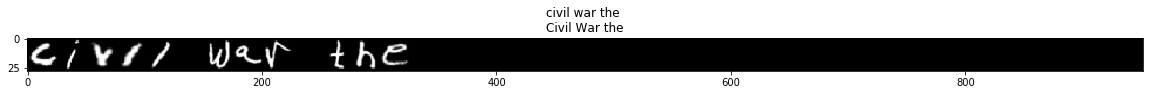

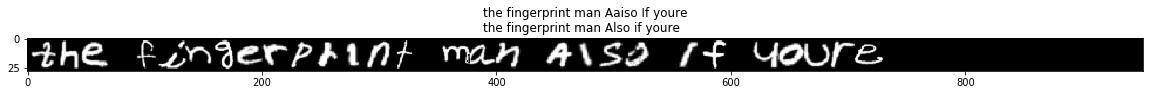

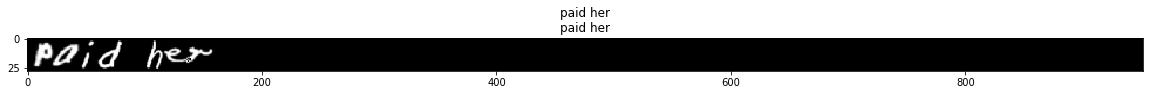

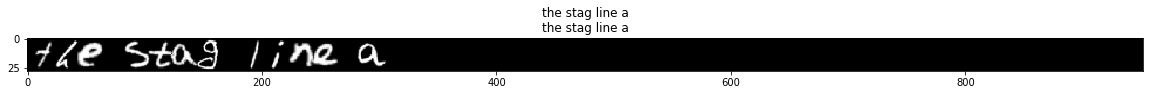

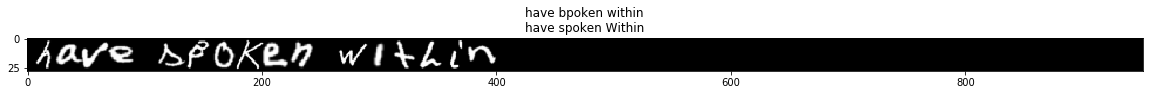

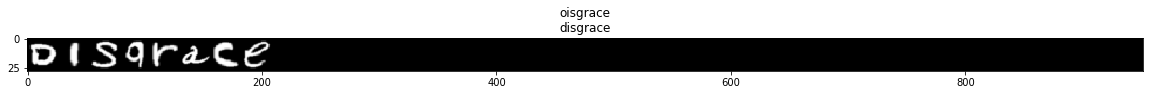

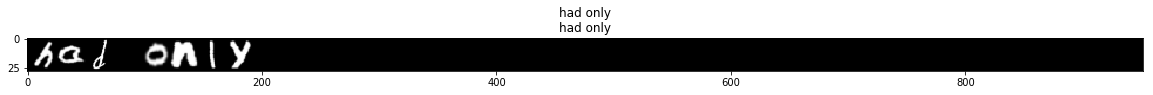

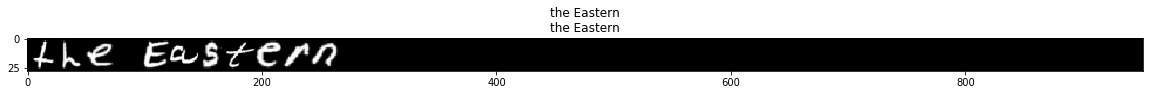

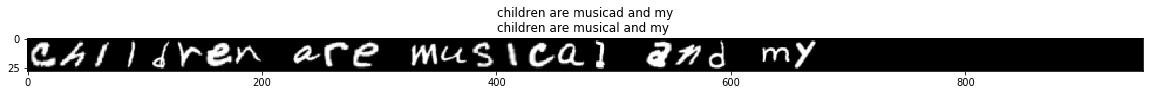

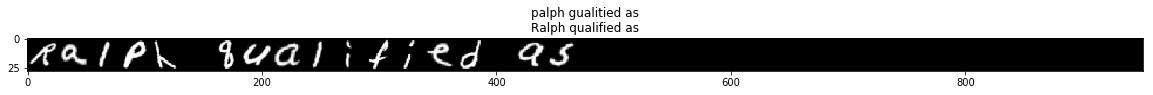

In [19]:
#lenet
# obtain one batch of test images
# get sample outputs
batch_size = 32
test_gen = test_generator(dataset, batch_size)
decoding_model = KerasModel(inputs=ctc.network.input, 
                            outputs=ctc.network.get_layer('ctc_decoded').output)
preds = decoding_model.predict_generator(test_gen, steps=1, verbose=2)
# convert output probabilities to predicted class
trues = np.argmax(dataset.y_test, axis=-1)
trues = trues[:32]
pred_strings = [''.join(dataset.mapping.get(label, '') for label in pred).strip(' |_') for pred in preds]
true_strings = [''.join(dataset.mapping.get(label, '') for label in true).strip(' |_') for true in trues]

images = dataset.x_test[:32]
# plot the images in the batch, along with predicted and true labels
for idx in np.arange(10):
    plt.figure(figsize=(20, 20))
    lbl = true_strings[idx]
    plt.title("{}\n{}".format(str(pred_strings[idx]), str(true_strings[idx])), ma='left')
    plt.imshow(images[idx], cmap='gray')

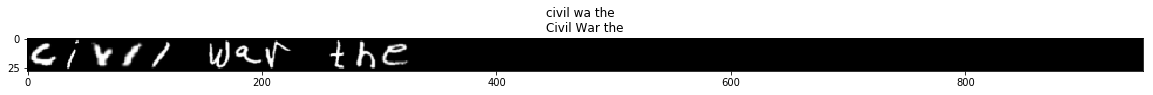

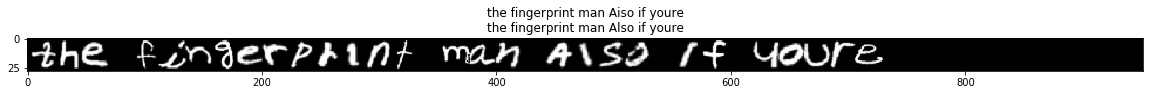

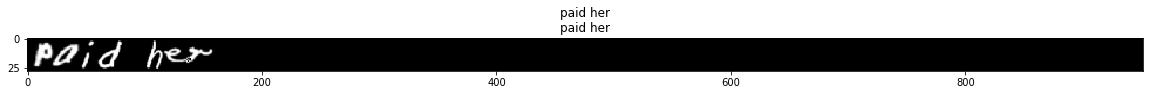

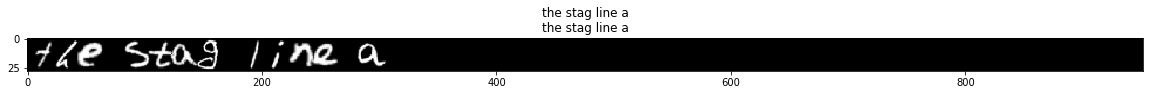

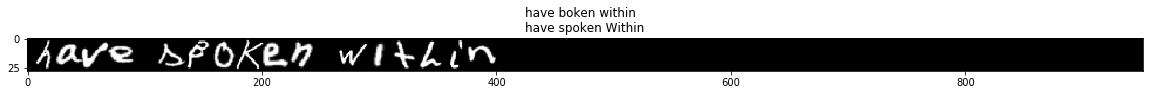

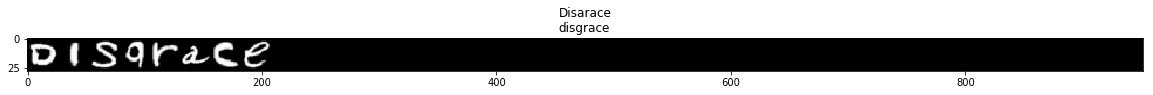

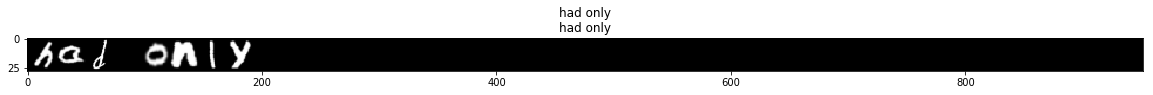

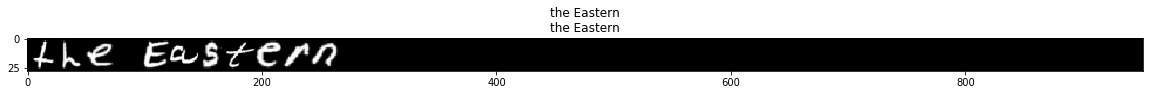

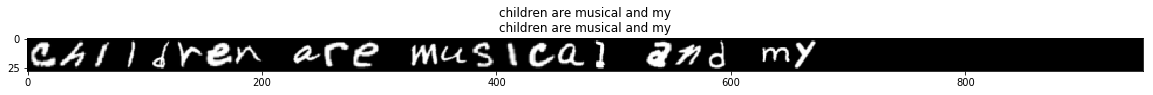

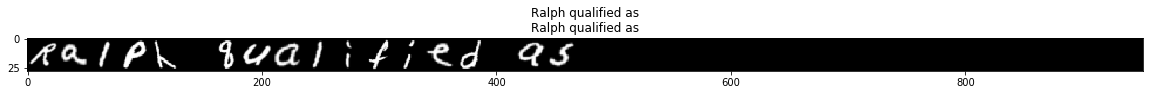

In [27]:
# custom
# obtain one batch of test images
# get sample outputs
batch_size = 32
test_gen = test_generator(dataset, batch_size)
decoding_model = KerasModel(inputs=ctc.network.input, 
                            outputs=ctc.network.get_layer('ctc_decoded').output)
preds = decoding_model.predict_generator(test_gen, steps=1, verbose=2)
# convert output probabilities to predicted class
trues = np.argmax(dataset.y_test, axis=-1)
trues = trues[:32]
pred_strings = [''.join(dataset.mapping.get(label, '') for label in pred).strip(' |_') for pred in preds]
true_strings = [''.join(dataset.mapping.get(label, '') for label in true).strip(' |_') for true in trues]

images = dataset.x_test[:32]
# plot the images in the batch, along with predicted and true labels
for idx in np.arange(10):
    plt.figure(figsize=(20, 20))
    lbl = true_strings[idx]
    plt.title("{}\n{}".format(str(pred_strings[idx]), str(true_strings[idx])), ma='left')
    plt.imshow(images[idx], cmap='gray')